# SBA Repay: Predicting Loan Defaults for Small Business Loans

## Table of Contents
1. [Initial Model Testing - Logistic Regression](#cell1)
2. [A Simple Decision Tree](#cell2)
3. [Random Forest](#cell3)
3. [Random Forest Feature Importances](#cell4)
3. [Focusing on Shorter Duration Loans](#cell5)




<a id="cell1"></a>
## 1. Initial Model Testing - Logistic Regression

In [1]:
#Import necessary Python packages 

#data analysis tools
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

#plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz 

#classification 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score

In [2]:
#Load cleaned data
data = pd.read_pickle('loans_7a_matured')

In [3]:
data.columns

Index([      'ApprovalFiscalYear',             'TermInMonths',
                 'RevolverStatus',            'JobsSupported',
               'FranchiseCodeBin',                'SP_to2016',
       'SBAGuaranteedApprovalAdj',                       'AL',
                             'AR',                       'AZ',
       ...
                             2008,                       2009,
                             2010,                       2011,
                             2012,                       2013,
                             2014,                       2015,
                             2016,                       2017],
      dtype='object', length=106)

We will **remove the approval year** information in order to make the model useful for future years (not included in the data).

In [4]:
data.drop(list(data.columns)[80:], axis = 1, inplace = True)
data.drop('ApprovalFiscalYear', axis = 1, inplace = True)

Target variable is Loan Status - Paid in Full (PIF) versus Defaulted. Right now:
* Negative class = defaulted.
* Postive class = repaid (paid in full).




In [5]:
data['PIF'].value_counts()

1    492214
0    158049
Name: PIF, dtype: int64

In [6]:
# Percent of loans that defaulted out of paid in full + defaulted loans
print(str(np.round(100*(data['PIF']==0).sum() / len(data), 2)) + '% of matured loans defaulted')

24.31% of matured loans defaulted


In [7]:
# Select the features
X = data.drop(['PIF'], axis = 1)
# Select the target variable: switch class labels so that "defaulted" is the postive class 
# since this is what we really care about
y = (1 - data['PIF'])

class_names = ['Paid in Full', 'Defaulted']

From here on: 
<br>
   **  Class 0 = Paid in Full <br>
     Class 1 = Defaulted **

We will first split our data into **training and testing** sets. We will use a **stratified** split since classes are somewhat imbalanced. We will always run model optimization/selection on the training data (by introducing an additional cross validation portion/k-fold cross validation) and testing on the untouched test set. 

In [8]:
# Set aside a test set
# Random stratified 70-30 split: preserves the original proportion of positive and negative class 
# examples in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                        test_size = 0.30, random_state = 101)

We will start with (L2-regularized) logistic regression with default hyperparameters. We will **scale all numeric features** prior to model training and testing. 

In [9]:
# Scale numerical features for logistic regression (with regularization)

from sklearn.preprocessing import StandardScaler

# Get scaling parameters from training data, then apply the scaler to testing data as well
std_scale = StandardScaler().fit(X_train[['TermInMonths', 'JobsSupported', 'SP_to2016', 'SBAGuaranteedApprovalAdj']])
X_train_std = std_scale.transform(X_train[['TermInMonths', 'JobsSupported', 'SP_to2016', 'SBAGuaranteedApprovalAdj']])
X_test_std = std_scale.transform(X_test[['TermInMonths', 'JobsSupported', 'SP_to2016', 'SBAGuaranteedApprovalAdj']])

We will first run logistic regression with default hyperparamters. We will use **class_weight = 'balanced'** to introduce higher penalty for missclassifying the minority class. 

In [10]:
# Define the model
def_logreg_model = LogisticRegression(class_weight = 'balanced', random_state = 101)
# Train the model on scaled training data
def_logreg_model.fit(X_train_std, y_train)
# Test the model: make predictions on testing data
def_logreg_pred = def_logreg_model.predict(X_test_std)
# Compare model outputs with actual outputs
print(classification_report(def_logreg_pred, y_test))

             precision    recall  f1-score   support

          0       0.76      0.90      0.82    123397
          1       0.75      0.50      0.60     71682

avg / total       0.75      0.75      0.74    195079



We should aim to avoid predicting that a loan will be paid in full, when in fact it will default, i.e., we want to detect all of defaults (positive class). False negatives should be important. Therefore, **we'll pay particular attention to recall ** (of the positive/Default class).

This is exactly the metric that the above classifier struggles with - it is 0.50. 
We can gain more insight as to what went wrong by examining the confusion matrix. 

In [11]:
# Function to display the confusion matrix - original or normalized

import itertools
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Blues, normalize = False):
    """
    This function prints and plots the confusion matrix.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 20)
    plt.xlabel('Predicted Label', fontsize = 20)
    plt.grid(False)

Confusion matrix, without normalization
[[111521  11876]
 [ 36143  35539]]
Normalized confusion matrix
[[ 0.90375779  0.09624221]
 [ 0.50421305  0.49578695]]


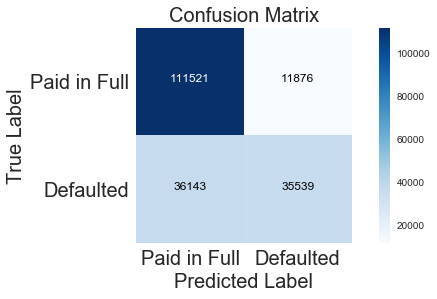

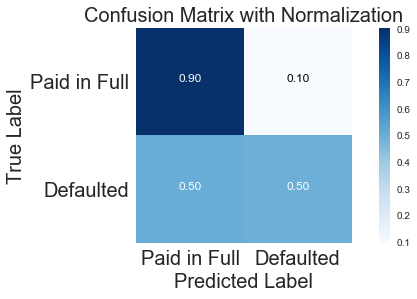

In [12]:
# Plot confusion matrix without normalization

def_logreg_cm = confusion_matrix(def_logreg_pred, y_test)

plt.figure(figsize = (8,4))
plot_confusion_matrix(def_logreg_cm, classes = class_names, normalize = False,
                      title = 'Confusion Matrix')# Plot normalized confusion matrix
plt.figure(figsize = (8,4))
plt.figure(figsize = (8,4))
plot_confusion_matrix(def_logreg_cm, classes = class_names, normalize = True,
                      title = 'Confusion Matrix with Normalization')

We see that many defaulted loans got labeled as paid in full (actually, as many as were classified correctly). We will try to improve the perofrmance by **optimizing hyperparamters** using a **Grid Search with 10-fold Cross Validation (stratified split)** on training data, picking the best model (optimal hyperparameters), and then applying it to the test data. One hyperparameter that is of importance to logistic regression is C - the amount of regularization used. 

In [13]:
# Tune the hyperparameters: vary the regularization paramter
# Try an exhaustive range of values

param_grid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000]}

# 10-fold cross validation on training data to tune C
grid_logmodel = GridSearchCV(LogisticRegression(class_weight = 'balanced'), 
                             param_grid, refit = True, verbose = 1,  
                             cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 101))
grid_logmodel.fit(X_train_std, y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  1.0min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=101, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.0005, 0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [14]:
# See the chosen optimal parameter
grid_logmodel.best_params_

{'C': 1}

Looks like the default parameter was the best choice! 

<a id="cell2"></a>
## 2. A Simple Decision Tree

We will next implement a simple decision tree model. We will limit the depth to four, for simplicity. 

In [15]:
# Train and test a simple decision tree with random stratified split and 10-fold cross validation.
# Better accuracy could be achieved without the max_depth and min_samples_leaf constraints,
# but we will aim for simplicity here (to avoid overfitting and it easier to visualize).

# Decision trees do not need features to be scaled. For easier interpretability, we will go back to original data.
dtree = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 5, class_weight = 'balanced')

# Fit/train the model 
dtree.fit(X_train, y_train)

# Test the model
dtree_pred = dtree.predict(X_test)
# Display results
print(classification_report(dtree_pred, y_test))

             precision    recall  f1-score   support

          0       0.77      0.97      0.86    117221
          1       0.94      0.57      0.71     77858

avg / total       0.84      0.81      0.80    195079



Normalized confusion matrix
[[ 0.97472296  0.02527704]
 [ 0.42906317  0.57093683]]


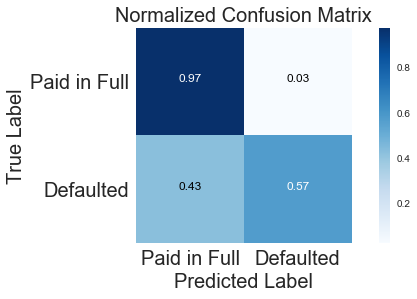

In [16]:
#Plot normalized confusion matrix
dtree_cm = confusion_matrix(dtree_pred, y_test)

plt.figure(figsize = (8,4))
plot_confusion_matrix(dtree_cm, classes = class_names, normalize = True,
                      title = 'Normalized Confusion Matrix')

We can see that, relative to logistic regression, this model is overall doing better - precision of the positive class has significantly improved (from 0.75 to 0.94). However, this is only  **slightly better** in terms of **recall** (0.50 to 0.57).  We would like to further improve recall as well. Let's see what an individual tree looks like.  

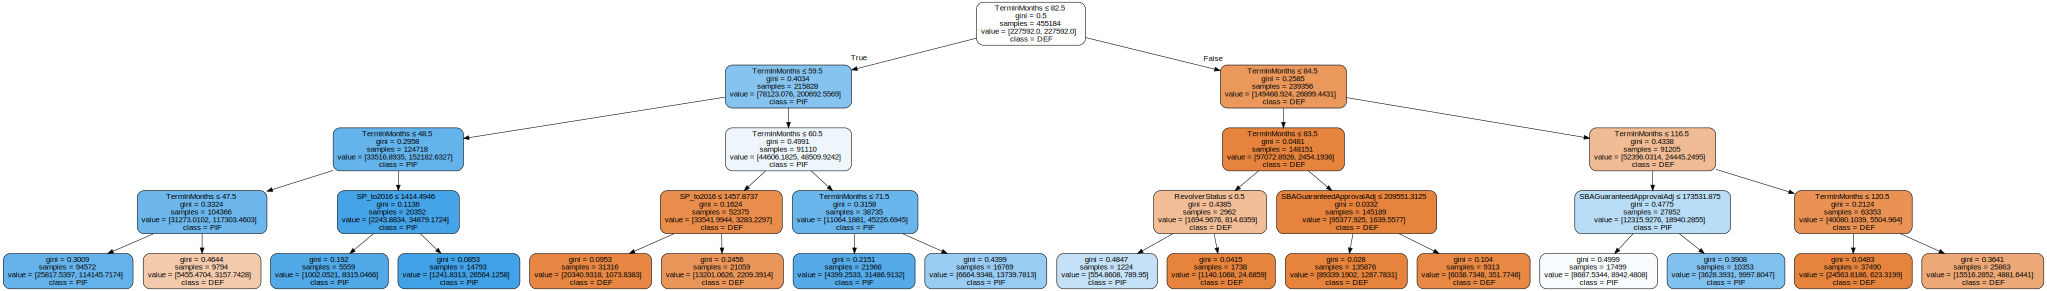

In [17]:
# Visualize the tree
dot_data = tree.export_graphviz(dtree, out_file = None, 
                         feature_names = X_train.columns,  
                         class_names = ['DEF', 'PIF'],  
                         filled = True, rounded = True,  
                         special_characters = True)  
graph = graphviz.Source(dot_data)  
graph.render("dec_tree_simple") 
graph


From the tree, it looks like the most important features are:
    * Term in Months (most decisions/splits are made based on this feature, and it looks like loans < 83 months are more likely to default)
    * S&P 1500 Index
    * Guaranteed Amount
    
Let's examine Term in Months in more detail. 
    

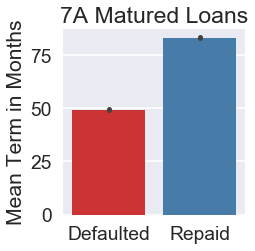

In [18]:
# Term in months seems to be the most important from the Decision Tree
fig = plt.figure(figsize = (5,3), facecolor = 'gainsboro')
sns.set_context('poster', font_scale = 1.2)


g = sns.factorplot(x = 'PIF', y = 'TermInMonths',
                   kind = 'bar', data = data, estimator = np.mean, palette = 'Set1' )

g.set_xticklabels(['Defaulted', 'Repaid'])
sns.plt.xlabel('')
sns.plt.title('7A Matured Loans')
sns.plt.ylabel('Mean Term in Months')
g.savefig('Term.png', dpi = 300)

It looks like paid in full loans have, on average, longer duration! 

<a id="cell3"></a>
## 3. Random Forest

To improve the performance further, we will use a random forest classifier: random forests are an ensemble learning method  that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes output by individual trees, or, in Scikit Learn implementation, average of probabilistic outputs of all trees. 

In [19]:
# Train and test a Random Forest classifier with default hyperparamters first (use 300 estimators to start with)
df_rf_n300 = RandomForestClassifier(n_estimators = 300, class_weight = 'balanced', n_jobs=-1)
# Fit/train the model
df_rf_n300.fit(X_train, y_train)
# Test the model: make predictions on the test set
df_rf_n300_pred = df_rf_n300.predict(X_test)
print(classification_report(y_test, df_rf_n300_pred))

             precision    recall  f1-score   support

          0       0.93      0.95      0.94    147664
          1       0.83      0.77      0.80     47415

avg / total       0.91      0.91      0.91    195079



This is much better compared to both logistic regression and single simple decision tree above. Let's tune the hyperparamters next. We will again use **10-fold cross validation with stratified splits** on the training data, pick the optimal parameters, and then apply the selected model to test data. 

We would will to look at a range of following hyperparameters:
        1. n_estimators - the number of trees
        2. max_features - the maximum number of features Random Forest is allowed to try in individual tree
        3. min_samples_leaf -  leaf is the end node of a decision tree - a smaller leaf makes the model more prone to capturing noise in training data
        
We will optimize for **f1 score** to acount for both precision and recall of Defaults. 

Due to high computational demands of grid search, we will first check if we can reduce the number of estimators, without affecting the performance. (the optimal way to do this would be to use a range of n_estimators in all possible combinations with other parameters we want to tune)

In [20]:
# Train and test a Random Forest classifier with default hyperparamters first - use 100 estimators 
df_rf_n100 = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', n_jobs=-1)
# Fit/train the model
df_rf_n100.fit(X_train, y_train)
# Test the model: make predictions on the test set
df_rf_n100_pred = df_rf_n100.predict(X_test)
print(classification_report(y_test, df_rf_n100_pred))

             precision    recall  f1-score   support

          0       0.93      0.95      0.94    147664
          1       0.83      0.76      0.79     47415

avg / total       0.90      0.90      0.90    195079



A random forest with 100 estimators achieves the same precision and recall as when using 300 estimators, so let's use at most 100 estimators. 

In [21]:
# GridSearch for RF
param_grid = {'max_features': [0.2, 'auto', 'log2'], 
              'n_estimators': [50, 100], 'min_samples_leaf': [1, 5, 10, 50, 100]}
grid_rf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced', n_jobs = 4),
                param_grid, cv = 10, refit = True, verbose = 3, scoring = 'f1')


In [22]:
grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.819527, total=  32.1s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.0s remaining:    0.0s


[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.824500, total=  32.5s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.821089, total=  32.3s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.824209, total=  31.9s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.825624, total=  32.2s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.820174, total=  32.2s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.819891, total=  32.0s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.818649, total=  31.7s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 180.4min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [0.2, 'auto', 'log2'], 'n_estimators': [50, 100], 'min_samples_leaf': [1, 5, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=3)

In [23]:
print(grid_rf.best_params_)

{'max_features': 0.2, 'min_samples_leaf': 1, 'n_estimators': 100}


In [24]:
grid_rf_pred = grid_rf.predict(X_test)

In [25]:
print(classification_report(grid_rf_pred, y_test))

             precision    recall  f1-score   support

          0       0.95      0.94      0.95    148874
          1       0.82      0.84      0.83     46205

avg / total       0.92      0.92      0.92    195079



In [26]:
opt_rf = RandomForestClassifier(n_estimators = 100, max_features = 0.2, min_samples_leaf = 1, class_weight='balanced')
opt_rf.fit(X_train, y_train) 
opt_rf_pred = opt_rf.predict(X_test)
print(classification_report(opt_rf_pred, y_test))

             precision    recall  f1-score   support

          0       0.95      0.94      0.94    149036
          1       0.81      0.84      0.82     46043

avg / total       0.92      0.92      0.92    195079



<a id="cell4"></a>
## 4. Random Forest Feature Importances

Let's examine which features are contributing most in the optimal Random Forest model. 

In [27]:
#Feature ranking for random forest
fig = plt.figure(figsize = (10,5))
importances = opt_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in opt_rf.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]
fts = list(X_train.columns)
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
   print("%d. feature %s (%f)" % (f + 1, fts[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature TermInMonths (0.575866)
2. feature SBAGuaranteedApprovalAdj (0.101732)
3. feature SP_to2016 (0.097691)
4. feature JobsSupported (0.047171)
5. feature RevolverStatus (0.013784)
6. feature INDIVIDUAL (0.007467)
7. feature CA (0.006855)
8. feature Retail Trade (0.005870)
9. feature FL (0.004868)
10. feature Construction (0.004829)
11. feature Other Services (0.004709)
12. feature Health Care & Social Assistance (0.004662)
13. feature TX (0.004635)
14. feature Manufacturing (0.004490)
15. feature NY (0.004467)
16. feature Professional, Scientific, & Technical Services (0.004407)
17. feature Wholesale Trade (0.004002)
18. feature FranchiseCodeBin (0.003866)
19. feature PA (0.003514)
20. feature OH (0.003276)
21. feature Administrative/Support/Waste Management (0.003274)
22. feature NJ (0.003119)
23. feature Transportation & Warehousing (0.002974)
24. feature GA (0.002890)
25. feature IL (0.002762)
26. feature MN (0.002755)
27. feature PARTNERSHIP (0.002685)
28. f

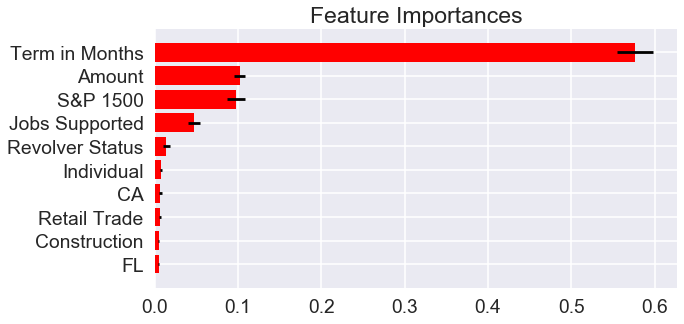

In [28]:
# Plot the top ten feature importances of the optimized random forest method
importances = opt_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in opt_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
fig = plt.figure(figsize = (10,5))

plt.title("Feature Importances")
plt.barh(range(10), importances[indices][0:10][::-1],
       color="r", xerr = std[indices][0:10][::-1], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(10), ['Term in Months', 'Amount', 'S&P 1500', 'Jobs Supported', 'Revolver Status',
                      'Individual', 'CA', 'Retail Trade', 'Construction', 'FL'][::-1])
    
plt.yticks(range(10))
plt.ylim([-1,10])
plt.tight_layout()


fig.savefig('OPTIMAL_RF_FImportance.png', dpi = 300)

Since Random Forests are nonlinear classifiers and we cannot tell if these features are having a negative or positive effect, let's try to infer the direction from the original data. 

In [29]:
# Check if there is a difference in mean duration
import scipy
from scipy.stats import ttest_ind
t, prob = scipy.stats.ttest_ind(data[data['PIF']==0]['TermInMonths'], data[data['PIF']==1]['TermInMonths'] )
print(t, prob)

-311.664506627 0.0


Looks like duration is significantly longer for paid in full loans. 

In [30]:
# Check if there is a difference in mean amount
t, prob = scipy.stats.ttest_ind(data[data['PIF']==0]['SBAGuaranteedApprovalAdj'], data[data['PIF']==1]['SBAGuaranteedApprovalAdj'] )
print(t, prob)

-33.4039391709 1.94024593685e-244


Average amount is lower for defaulted loans. 

In [31]:
# Check if there is a difference in mean number of jobs
t, prob = scipy.stats.ttest_ind(data[data['PIF']==0]['JobsSupported'], data[data['PIF']==1]['JobsSupported'] )
print(t, prob)

5.73036927693 1.00256282317e-08


In [32]:
#Examine loans with TermDuration = 84
data_84 = data[data['TermInMonths'] == 84]
data_84.reset_index(inplace=True, drop = True)

In [33]:
data_84['PIF'].value_counts()

1    206616
0      1157
Name: PIF, dtype: int64

For loans of duration = 84 months, < 0.5% default!

<a id="cell5"></a>
## 5. Focusing on Shorter Duration Loans

Let's examine loans with duration < 84 months and repeat all the steps from above without TermInMonths. 

In [34]:
# Consider only loans with TermDuration < 84
data_l84 = data[data['TermInMonths'] < 84]
data.reset_index(inplace = True, drop = True)

target_l84 = y = (1 - data[data['TermInMonths'] < 84]['PIF'])

In [35]:
# Split into training and testing data as before
X_train_l84, X_test_l84, y_train_l84, y_test_l84 = train_test_split(data_l84.drop(['TermInMonths',  'PIF'],axis = 1), 
                                                                target_l84, 
                                                                stratify = target_l84,
                                                                test_size = 0.30, random_state = 101)

In [36]:
# Logistic Regression Classification 
logmodel_l84 = LogisticRegression(class_weight = 'balanced')
logmodel_l84.fit(X_train_l84, y_train_l84)
lm_l84_pred = logmodel_l84.predict(X_test_l84)
print(classification_report(y_test_l84, lm_l84_pred))

             precision    recall  f1-score   support

          0       0.59      0.15      0.24     51666
          1       0.46      0.87      0.60     41974

avg / total       0.53      0.48      0.40     93640



In [37]:
# GridSearch for Logistic Regression
param_grid = {'C': [0.001, 0.005, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]}
grid_l84 = GridSearchCV(LogisticRegression(class_weight = 'balanced'), param_grid, refit=True,verbose=1)
grid_l84.fit(X_train_l84, y_train_l84)
print(grid_l84.best_params_)



Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:  1.2min finished


{'C': 0.001}


In [38]:
grid_l84_pred = grid_l84.predict(X_test_l84)

print(classification_report(y_test_l84, grid_l84_pred))

             precision    recall  f1-score   support

          0       0.59      0.15      0.24     51666
          1       0.46      0.87      0.60     41974

avg / total       0.53      0.48      0.40     93640



Again, Logistic Regression does not seem to be sufficient.
We will again tune hyperparamters for Random Forest using grid search with cross validation. 

In [39]:
# GridSearch for Random Forest
param_grid = {'max_features': [0.2, 'auto', 'log2'],
              'n_estimators': [50, 100], 'min_samples_leaf': [1, 5, 10, 50, 100]}
grid_rf_l84 = GridSearchCV(RandomForestClassifier(class_weight = 'balanced', n_jobs = 4),
                param_grid, cv = 10, refit = True, verbose = 3, scoring = 'f1')


In [40]:
grid_rf_l84.fit(X_train_l84, y_train_l84)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.666631, total=  12.8s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s


[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.662346, total=  12.9s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.2s remaining:    0.0s


[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.654345, total=  12.8s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.663999, total=  12.8s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.660588, total=  12.2s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.659413, total=  12.3s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.662374, total=  12.1s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_samples_leaf=1, n_estimators=50, score=0.653367, total=  12.3s
[CV] max_features=0.2, min_samples_leaf=1, n_estimators=50 ...........
[CV]  max_features=0.2, min_

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 68.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [0.2, 'auto', 'log2'], 'n_estimators': [50, 100], 'min_samples_leaf': [1, 5, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=3)

In [41]:
print(grid_rf_l84.best_params_)

{'max_features': 0.2, 'min_samples_leaf': 5, 'n_estimators': 100}


In [42]:
# Run RF with optimal paramters 
opt_rf_l84 = RandomForestClassifier(class_weight = 'balanced', max_features = 0.2, min_samples_leaf = 5, n_estimators = 100)
opt_rf_l84.fit(X_train_l84, y_train_l84)
opt_rf_l84_pred = opt_rf_l84.predict(X_test_l84)

In [43]:
print(classification_report(y_test_l84, opt_rf_l84_pred))

             precision    recall  f1-score   support

          0       0.75      0.75      0.75     51666
          1       0.69      0.70      0.70     41974

avg / total       0.73      0.73      0.73     93640



Random Forest, again, performs much better than Logistic Regression. 
Let's compare the performance with a **random model**. We will define this classifier as  one that is aware of the proportion (imblance) of classes in the training data, and makes predictions on testing data according to the ratio of positive and negative examples it sees in the training data. 

In [44]:
# Build a random/control models to compare Random Forest performance with

# proportion of positive class in training data
pos_prop = np.sum(y_train_l84)/len(y_train_l84)  

expected_pos_in_test = np.round(pos_prop*(len(y_test_l84)))
               
                
#control predicts accroding to proportions of positive and negative examples in the training data
zs = np.zeros(len(y_test_l84) - int(expected_pos_in_test)) #zeros
os = np.ones((int(expected_pos_in_test)))
                
zo = np.concatenate((zs, os))
                
y_test_control = np.random.permutation(zo)              

In [45]:
print(classification_report(y_test_l84, y_test_control))

             precision    recall  f1-score   support

          0       0.55      0.55      0.55     51666
          1       0.45      0.45      0.45     41974

avg / total       0.50      0.50      0.50     93640



Random (control) model has much lower precision and recall than random forest for loans with duration < 84 months.
Let's again examine feature importances. 

In [46]:
# Feature ranking for random forest
fig = plt.figure(figsize = (15,5))
importances_rf_l84 = opt_rf_l84.feature_importances_
std = np.std([tree.feature_importances_ for tree in opt_rf_l84.estimators_],
            axis=0)
indices_rf_l84 = np.argsort(importances_rf_l84)[::-1]
fts_rf_l84 = list(X_train_l84.columns)
# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_l84.shape[1]):
   print("%d. feature %s (%f)" % (f + 1, fts_rf_l84[indices_rf_l84[f]], importances_rf_l84[indices_rf_l84[f]]))

Feature ranking:
1. feature SP_to2016 (0.289196)
2. feature SBAGuaranteedApprovalAdj (0.223007)
3. feature JobsSupported (0.106649)
4. feature RevolverStatus (0.034330)
5. feature CA (0.031564)
6. feature FL (0.028554)
7. feature INDIVIDUAL (0.016419)
8. feature Retail Trade (0.014239)
9. feature GA (0.012046)
10. feature FranchiseCodeBin (0.011234)
11. feature TX (0.010899)
12. feature Health Care & Social Assistance (0.010268)
13. feature NY (0.008815)
14. feature Construction (0.008623)
15. feature PA (0.008377)
16. feature Professional, Scientific, & Technical Services (0.008231)
17. feature MA (0.008086)
18. feature Other Services (0.007896)
19. feature Wholesale Trade (0.007742)
20. feature Manufacturing (0.007437)
21. feature IL (0.006598)
22. feature Transportation & Warehousing (0.006583)
23. feature PR (0.006115)
24. feature AZ (0.005460)
25. feature Administrative/Support/Waste Management (0.005118)
26. feature MT (0.005055)
27. feature OH (0.004972)
28. feature NJ (0.004888

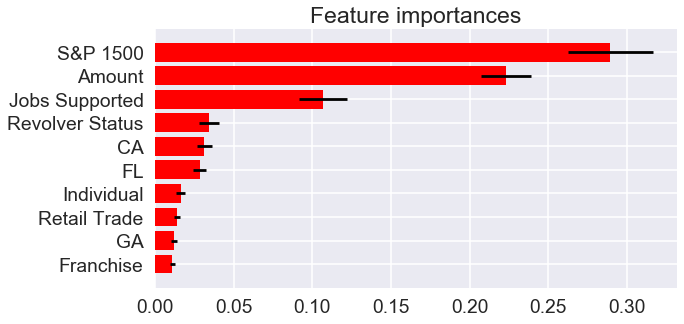

In [47]:
# Plot the feature importances of the forest
importances = opt_rf_l84.feature_importances_
std = np.std([tree.feature_importances_ for tree in opt_rf_l84.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
fig = plt.figure(figsize = (10,5))

plt.title("Feature importances")
plt.barh(range(10), importances[indices][0:10][::-1],
       color="r", xerr=std[indices][0:10][::-1], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(10), ['S&P 1500', 'Amount', 'Jobs Supported', 'Revolver Status',
                       'CA',  'FL', 'Individual', 'Retail Trade', 'GA', 'Franchise'][::-1])
    
plt.ylim([-1,10])
plt.tight_layout()


fig.savefig('L84_RF_FImportance.png', dpi = 300)

This is similar to what we had before - the S&P 1500 and the amount of the loan are the most important factors, followed by the number of jobs the business supports.